# Template Pipeline
Normalisation&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**X -> Gaussian**  
Imputation 1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Median**  
Outlier Detection&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Z Score**  
Imputation 2&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Median**  
Feature Selection&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Implicit to model**  
Model&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**Lasso Regression**


## Imports

In [ ]:
!pip install tensorflow

You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# General
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ML
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, BayesianRidge
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score

import tensorflow as t
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import KFold
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, BatchNormalization
import sklearn
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
# Custom
import sys,os
sys.path.append('/home/jovyan/work/AML/Task_1/Solution') # I would like a cleaner solution but works for now
import Components.Imputation as Imputation
import Components.Outlier_Detection_1D as Outlier_Detection_1D
import Components.Outlier_Detection_ND as Outlier_Detection_ND
import Components.Feature_Selection as Feature_Selection
import Components.Normalisation as Normalisation
import Components.data_fetching as data_fetching
import Components.data_observations as data_observations

# CAREFUL:
# If you make changes to a custom module, you have to reload it, i.e rerun this cell
import importlib
importlib.reload(Imputation)
importlib.reload(Outlier_Detection_1D)
importlib.reload(Outlier_Detection_ND)
importlib.reload(Feature_Selection)
importlib.reload(Normalisation)
importlib.reload(data_fetching)
importlib.reload(data_observations)

<module 'Components.data_observations' from '/home/jovyan/work/AML/Task_1/Solution/Components/data_observations.py'>

## Data Cleaning

In [ ]:
verbose = True
X, y = data_fetching.get_train_data()

missing_vals_mask = Imputation.missing_values_mask(X)
X = Imputation.median(X)
#X,y, missing_vals_mask = Outlier_Detection_ND.mahalanobis_distance(X,y, missing_vals_mask, verbose=verbose)
X,y, missing_vals_mask = Outlier_Detection_ND.magic_indices(X,y, 100, missing_vals_mask,verbose=verbose)

X = Normalisation.gaussian(X)
X = Outlier_Detection_1D.z_score(X, verbose)
X = X.mask(missing_vals_mask) # Re-impute the ones we imputed before
X = Imputation.mean(X)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

# Outliers:  [ 323  333  215 1094 1179  774  527  826  981  673  313  765 1022  487
  627  657 1199  431   42  789  240  923  989  890  988  317 1182   16
  412  809  120   62  357 1078 1000  136  818  571  344   34  942 1189
  845 1042  204  537  960 1201  390  908  990  611  811  880  875 1021
 1205  968  884  270 1115  639  200 1067 1117 1070 1130  947  559 1098
  920  927  854 1195 1100  900 1157  899 1036  869  384  251  911 1135
  228 1009 1209 1128 1197  733 1063  859  905  459  146  110 1113 1096
 1093 1162]
/home/jovyan/work/AML/Task_1/Solution/Components/Outlier_Detection_ND.py:47: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if mask == '':
# Outliers:  1244


## Model Training

### Simple

In [ ]:
# welcome to the overfitting party!

def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(64, input_dim=832, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(64, input_dim=128, kernel_initializer='normal', kernel_regularizer=regularizers.l1(0.001)))
    #model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    model.add(Activation('relu'))
    model.add(Dense(32, input_dim=64, kernel_initializer='normal', kernel_regularizer=regularizers.l2(0.1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[coeff_determination])
    return model
# evaluate model
estimator = KerasRegressor(build_fn=baseline_model, epochs=3500, batch_size=70, verbose=1)
kfold = KFold(n_splits=2)
#estimator.fit(x_train, y_train)
#results = cross_val_score(estimator, x_train, y_train, cv=kfold, scoring='r2')
#print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))

print('Test Score')
y_pred_test = estimator.predict(x_test)
test_score = r2_score(y_test, y_pred_test)
print(test_score)

Test Score


AttributeError: 'KerasRegressor' object has no attribute 'model'

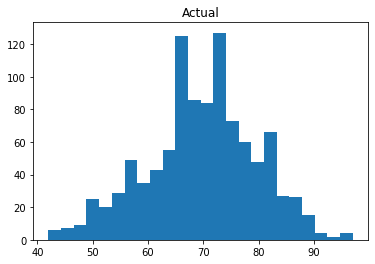

NameError: name 'y_pred_train' is not defined

In [ ]:
plt.hist(y_train.iloc[:,0].to_numpy(), bins='auto')
plt.title('Actual')
plt.show()

plt.hist(y_pred_train, bins='auto')
plt.title('Prediction')
plt.show()

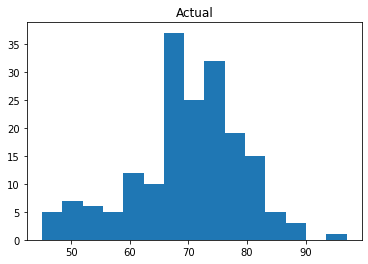

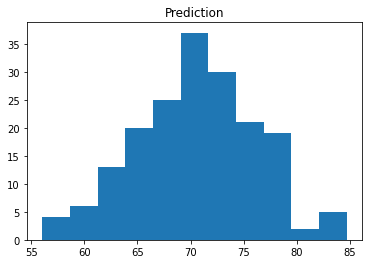

In [ ]:
plt.hist(y_test.iloc[:,0].to_numpy(), bins='auto')
plt.title('Actual')
plt.show()

plt.hist(y_pred_test, bins='auto')
plt.title('Prediction')
plt.show()

## Final Prediction

Test Score
16/16 [==============================] - 0s 1ms/step
0.9687478645321344
12/12 [==============================] - 0s 17ms/step
           y
0  65.919220
1  74.979790
2  63.795074
3  70.620720
4  70.801605


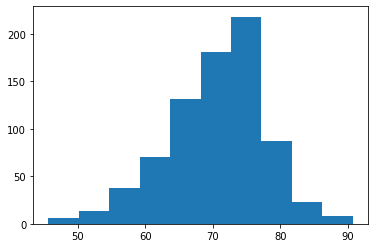

In [ ]:
# lasso_final = Lasso(normalize=False, max_iter=1000, alpha=0.35).fit(X, y)
#final = estimator.fit(X, y)
x_test = data_fetching.get_test_data()
print('Test Score')
y_pred_test = estimator.predict(X)
test_score = r2_score(y, y_pred_test)
print(test_score)
x_test = Imputation.mean(x_test)
x_test = Normalisation.gaussian(x_test)

# Note: They said no outliers were introduced in x_test so no need to perform outlier detection
y_pred = estimator.predict(x_test)
plt.hist(y_pred)

y_pred_pd = pd.DataFrame(data=y_pred, columns=["y"])
print(y_pred_pd.head())
y_pred_pd.to_csv('../../Predictions/nn.csv', index_label='id')